# **TP05 - Máquina de vectores soporte (SVM)**



In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from sklearn.preprocessing import LabelEncoder
import cvxopt
from matplotlib.lines import Line2D

In [5]:
# Cargar el dataset 'geyser'
geyser = sns.load_dataset('geyser')

# Mostrar las primeras filas del dataset
print(geyser.head())

   duration  waiting   kind
0     3.600       79   long
1     1.800       54  short
2     3.333       74   long
3     2.283       62  short
4     4.533       85   long


## **SVM**

Una **Máquina de Vectores de Soporte (SVM)** es un algoritmo de clasificación supervisada que busca encontrar el **hiperplano óptimo** que separa dos clases de datos.

A diferencia de otros clasificadores, una SVM no solo busca separar las clases correctamente, sino que intenta hacerlo **maximizando el margen**, es decir, la distancia entre la frontera de decisión y los puntos más cercanos de cada clase.

Estos puntos más cercanos al hiperplano se llaman **vectores soporte**, y son los únicos que definen la solución final. Los puntos más alejados no influyen en la posición del hiperplano.

### Margen

El margen de una SVM se define como la distancia entre el hiperplano y las muestras más cercanas. Como criterio se toma el **margen unilateral** como:

$$
m(w, b) = \min_{1 \leq i \leq n} \frac{y_i(w^T x_i + b)}{\|w\|} = \frac{1}{\|w\|} \min_{1 \leq i \leq n} f_i(w, b)
$$

donde $ f_i(w, b) = y_i(w^T x_i + b) $.

El objetivo es **maximizar ese margen**, es decir:

$$
\max_{w,b} \; m(w, b) \quad \text{tal que } f_i(w, b) > 0 \quad \forall i
$$


### Escala

Se puede ver que la decisión $ z(x) = w^T x + b $ no se ve afectada si multiplicamos $ w $ y $ b $ por un parámetro $ \alpha > 0$, por lo tanto, la frontera de decisión tampoco se ve afectada por éste reescalamiento.

Entonces, no se pierde generalidad si se reescala $ w $ y $ b $ de manera tal que :

$$
f_k(w, b) = 1 \quad \text{(donde \( k \) es el índice de una muestra que toca el margen)}
$$

Con esto, podemos expresar el margen como:

$$
m(w, b) = \frac{1}{\|w\|}
$$

Y la condición de clasificación para todos los puntos se convierte en:

$$
y_i(w^T x_i + b) \geq 1 \quad \forall i
$$

---

### **SVM con hard margin**

Supongamos un conjunto de entrenamiento con muestras $ (x_i, y_i) $, donde:
- $ x_i \in \mathbb{R}^d $ es un vector de características,
- $ y_i \in \{-1, 1\} $ es la etiqueta de clase.

Queremos encontrar un hiperplano definido por un vector $ w $ y un sesgo $ b $ tal que:

$$
f(x) = w^T x + b
$$

Con esto podemos definir el problema de optimización primal: 

$$
\begin{aligned}
\min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 \quad \forall i
\end{aligned}
$$

Este es un **problema de optimización cuadrática con restricciones lineales**, ideal para resolver mediante programación cuadrática usando herramientas como `solve_qp`.

---

### **solve_qp**

`solve_qp` es una función de la librería `qpsolvers` que resuelve un problema de programación cuadrática (QP) de la forma estándar:

$$
\text{min} \quad \frac{1}{2} z^T P z + q^T z \quad (1)
$$

sujeto a:

$$
Gz \leq h
$$
$$
A z = b
$$

Donde:

- `z` es el vector de variables que queremos encontrar.
- `P` es una matriz simétrica y semidefinida positiva que define el término cuadrático de la función objetivo.
- `q` es el vector que define el término lineal de la función objetivo.
- `G` y `h` definen las restricciones de desigualdad.
- `A` y `b` definen las restricciones de igualdad.

Por lo tanto, para resolver el problema primal de una SVM, debemos definir estas matrices y vectores.

Partiendo del problema primal con hard-margin, queremos minimizar:

$$
\frac{1}{2} \|w\|^2 
$$

sujeto a:

$$
y_i(w^T x_i + b) \geq 1 
$$

Esto se traduce en:

- `P`: matriz que penaliza los términos cuadráticos (solo se aplica a `w`).
- `q`: vector nulo, ya que no hay penalización por variables de holgura.
- `G` y `h`: construyen las restricciones $ -y_i(w^T x_i + b) \leq -1 $.
- No se usan restricciones de igualdad en el primal, por lo que `A` y `b` no son necesarios.



---

### **Implementación**

Para poder implmentar el algoritmo de Máquina de Vectores Soporte, se creó una clase `SVM` que recibe como párametros `C` (hiperparametro de regularización que se explicará más adelante) y `dual` que es un booleano que indica si queremos resolver el problema primal y dual.

Para entrenar la SVM, implementamos el método `fit` que recibe los datos de entrada `X` y las etiquetas `y`. Asumimos que las etiquetas de `y` son 0s o 1s, entonces lo primero que hacemos es modificar las etiquetas de manera tal que aquellas que pertenecían a la clase 0, ahora tengan un valor de -1.

Luego en este caso que queremos implementar el problema primal, dentro de `fit` se llama al método `_fit_primal` pasando como argumentos `X` e `y`.


Dentro de `_fit_primal`, teniendo en cuenta el problema que resuelve `solve_qp` es:

$$
\left( \min \frac{1}{2} z^T P z + q^T z \quad \text{sujeto a:} \quad Gz \leq h,  A z = b  \right)
$$

y que el problema primal con hard margin es:

$$
\begin{aligned}
\min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 \quad \forall i
\end{aligned}
$$


  
Entonces, en este caso, el vector de variables de decisión $z$ es `[w₁, ..., w_n, b]`.  

Por lo tanto la matriz del término cuadrático $P$ tiene una identidad en la parte correspondiente a `w` y ceros en el resto.

En el caso del vector $q$, para hard-margin, dado que no hay término lineal, éste vector es nulo.

Siguiendo con $G$ y $h$, que son las encargadas de definir las restricciones de desigualdad, que para este caso es: $y_i(w^T x_i + b) \geq 1$, esto se codifica como una fila en `G`, y el `-1` va en `h`.

Como no tenemos restricciones de igualdad, no hace falta definir $A$ y $b$.

Una vez que definimos las matrices $P$, $q$, $G$ y $h$, utilizamos la función `solve_qp` con estos parámetros y configuramos el solver a utilizar como `solver='cvxopt'`. Con ésto obtenemos el vector de variables de decisión $z$, por lo tanto nos quedamos con los primeros n valores para definir $w$ y los demas son los valores de $b$.


Para la etapa de testeo se implementa la función `predict`, que recibe un vector de entradas `X` y en base a este devuelve la clase predicha con:

$$
\text{sign} \left( w^T X + b \right)
$$





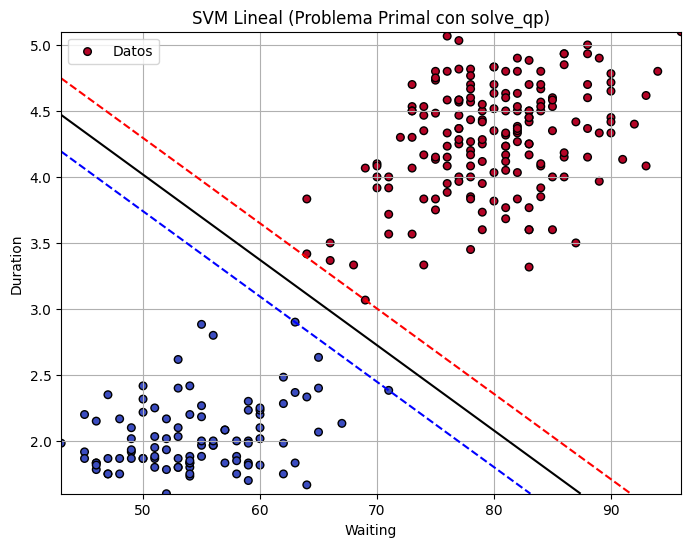

In [ ]:

class SVM:
    def __init__(self, C=1.0, dual=False, soft=False):
        self.C = C
        self.dual = dual
        self.soft = soft

    def fit(self, X, y):
        y = y.astype(np.float64)
        y[y == 0] = -1

        if self.dual:
            self._fit_dual(X, y)
        else:
            self._fit_primal(X, y)

    def _fit_primal(self, X, y):
        n_samples, n_features = X.shape

        if self.soft:
            # Variables: [w (n_features), b, xi (n_samples)]
            P = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
            P[:n_features, :n_features] = np.eye(n_features)

            q = np.zeros(n_features + 1 + n_samples)
            q[n_features + 1:] = self.C

            G = np.zeros((2 * n_samples, n_features + 1 + n_samples))
            h = np.zeros(2 * n_samples)

            for i in range(n_samples):
                G[i, :n_features] = -y[i] * X[i]
                G[i, n_features] = -y[i]
                G[i, n_features + 1 + i] = -1
                h[i] = -1

                G[n_samples + i, n_features + 1 + i] = -1
                h[n_samples + i] = 0

        else:  # hard-margin
            # Variables: [w (n_features), b]
            P = np.zeros((n_features + 1, n_features + 1))
            P[:n_features, :n_features] = np.eye(n_features)

            q = np.zeros(n_features + 1)

            G = np.zeros((n_samples, n_features + 1))
            h = -np.ones(n_samples)

            for i in range(n_samples):
                G[i, :n_features] = -y[i] * X[i]
                G[i, n_features] = -y[i]

        solution = solve_qp(P, q, G, h, solver='cvxopt')
        self.w = solution[:n_features]
        self.b = solution[n_features]

        if self.soft:
            self.xi = solution[n_features + 1:]

    def _fit_dual(self, X, y):
        n_samples, n_features = X.shape
        K = X @ X.T
        Q = np.outer(y, y) * K

        P = Q
        q = -np.ones(n_samples)

        A_eq = y.reshape(1, -1)
        b_eq = np.array([0.])

        if self.soft:
            G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
            h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C])
        else:  # hard-margin
            G = -np.eye(n_samples)
            h = np.zeros(n_samples)

        alpha = solve_qp(P, q, G, h, A_eq, b_eq, solver='cvxopt')

        self.alpha = alpha
        self.support_ = alpha > 1e-5
        self.X_sv = X[self.support_]
        self.y_sv = y[self.support_]
        self.alpha_sv = alpha[self.support_]

        self.w = (self.alpha_sv * self.y_sv) @ self.X_sv
        self.b = np.mean(self.y_sv - self.X_sv @ self.w)

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

    def decision_function(self, X):
        return X @ self.w + self.b


# ------------------ PARTE PRINCIPAL -------------------

# Cargar el dataset
geyser = sns.load_dataset('geyser').dropna()
X = geyser[['waiting', 'duration']].values

# Crear etiquetas binarias: duración > 3 min -> clase 1, si no -> clase 0
y = (geyser['duration'] > 3).astype(int).values

# Crear el modelo y entrenarlo
model_primal = SVM()
model_primal.fit(X, y)

# Predecir
y_pred = model_primal.predict(X)

# ------------------ GRAFICAR -------------------

# Scatter de datos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Frontera de decisión
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model_primal.decision_function(grid).reshape(xx.shape)

# Dibujar frontera y márgenes
plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--', '-', '--'])
plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Problema primal con hard margins')
plt.legend()
plt.grid(True)
plt.show()


---

### **SVM dual con Hard Margin**

Queremos resolver el problema dual de la SVM, para ello partimos del problema primal que se define:

$$
\begin{aligned}
J_1 = \min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{sujeto a} \quad & y_i(w^T \phi(x_i) + b) \geq 1 \quad \forall i
\end{aligned}
$$

Donde $ \phi(x_i) $ representa el mapeo de los datos a un espacio de características (por ejemplo, a través de un kernel).

Estem problema se puede reescribir utilizando multiplicadores de Lagrange $ \alpha_i \geq 0 $: 

$$
J_1 = \min_{w, b} \max_{\alpha_i \geq 0}  \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i \left[ y_i(w^T \phi(x_i) + b) - 1 \right]
$$

Queremos ahora encontrar el dual, resolviendo:

$$
J_2 = \max_{\alpha_i \geq 0} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i \left[ y_i(w^T \phi(x_i) + b) - 1 \right]
$$

Desarrollando:


$$
J_2 = \max_{\alpha_i \geq 0} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i y_i w^T \phi(x_i) - \sum_{i=1}^n \alpha_i y_i b + \sum_{i=1}^n \alpha_i
$$


Calculamos las derivadas parciales para minimizar respecto a $ w $ y $ b $:

- Derivada respecto a $ w $:

$$
\frac{\partial J_2}{\partial w} = w - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0
\Rightarrow \boxed{w = \sum_{i=1}^n \alpha_i y_i \phi(x_i)}
$$

- Derivada respecto a $ b $:

$$
\frac{\partial J_2}{\partial b} = -\sum_{i=1}^n \alpha_i y_i = 0
\Rightarrow \boxed{\sum_{i=1}^n \alpha_i y_i = 0}
$$


Sustituimos $ w $ y $ b $ en $ J_2 $, y obtenemos:

$$
J_2 = \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) + \sum_{i=1}^n \alpha_i
$$

- El término con $ b $ desaparece porque $ \sum \alpha_i y_i = 0 $
- $\sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) = w^T \sum_{i=1}^n \alpha_i y_i \phi(x_i) = w^T w = \| w\|^2$

Por lo que reescribiendo, llegamos a que:

$$
J_2 = \min_{\alpha_i} \sum_{i=1}^n \alpha_i - \| w \|^2
$$

$\| w \|^2$ se convierte en una suma doble utilizando el resultado de $w$:

$$
\begin{aligned}
\|w\|^2 &= \left\| \sum_{i=1}^n \alpha_i y_i \phi(x_i) \right\|^2 \\
&= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \phi(x_i)^T \phi(x_j)
\end{aligned}
$$

Con esto podemos definir la **matriz $ Q $** como:

$$
Q_{ij} = y_i y_j \phi(x_i)^T \phi(x_j)
$$

Por lo tanto, podemos escribir la norma como:

$$
\|w\|^2 = \alpha^T Q \alpha
$$


Con todo ésto se obtiene finalmente el problema **dual** como:

$$
\begin{aligned}
\max_{\alpha} \quad & \mathbf{1}^T \alpha - \frac{1}{2} \alpha^T Q \alpha \\
\text{sujeto a} \quad & \alpha^T y = 0 \\
& \alpha_i \geq 0 \quad \forall i
\end{aligned}
$$

Este problema cuadrático se puede resolver usando técnicas de **programación cuadrática (QP)**.

El sesgo $ b $, en el problema dual, se puede estimar de la siguiente forma:

$$
b = \frac{1}{N_S} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j \in \mathcal{S}} \alpha_j y_j \phi(x_j)^T \phi(x_i) \right)
$$

donde $\mathcal{S}$ es el conjunto de índices de vectores soporte y $N_s$ la cantidad de elementos de dicho conjunto.




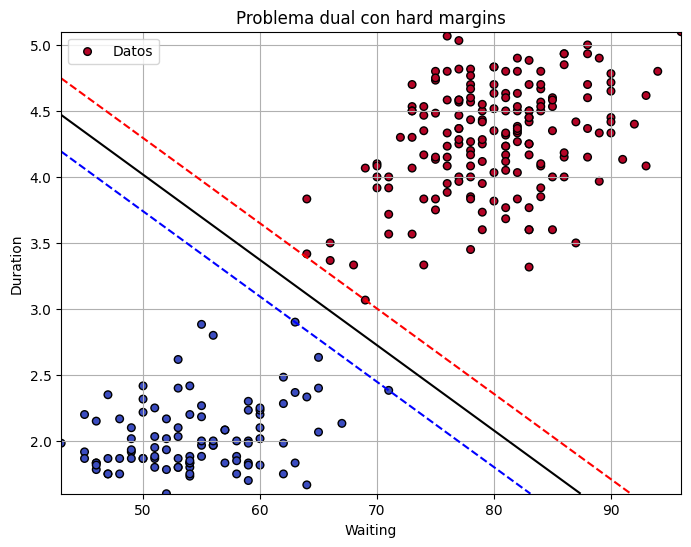

In [8]:
# Cargar el dataset
geyser = sns.load_dataset('geyser').dropna()
X = geyser[['waiting', 'duration']].values

# Crear etiquetas binarias: duración > 3 min -> clase 1, si no -> clase 0
y = (geyser['duration'] > 3).astype(int).values

# Crear el modelo y entrenarlo
model_dual = SVM(soft=False, dual=True)
model_dual.fit(X, y)

# Predecir
y_pred = model_dual.predict(X)

# ------------------ GRAFICAR -------------------

# Scatter de datos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Frontera de decisión
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model_dual.decision_function(grid).reshape(xx.shape)

# Dibujar frontera y márgenes
plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--', '-', '--'])
plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Problema dual con hard margins')
plt.legend()
plt.grid(True)
plt.show()

--- 

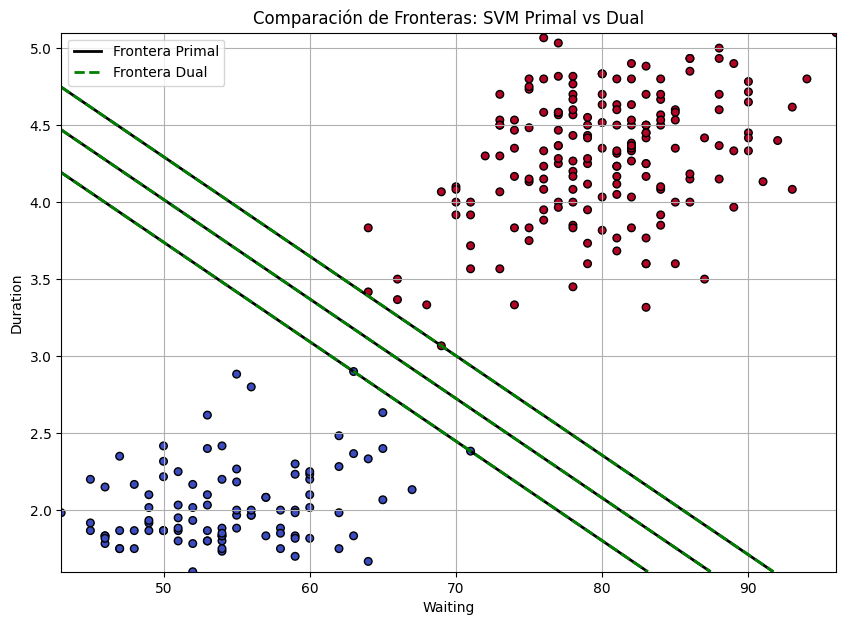

In [ ]:
# grafico de comparacion

plt.figure(figsize=(10, 7))

# Scatter de los puntos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Malla para evaluar
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# Fronteras
Z_primal = model_primal.decision_function(grid).reshape(xx.shape)
Z_dual = model_dual.decision_function(grid).reshape(xx.shape)

# Graficar fronteras
plt.contour(xx, yy, Z_primal, levels=[-1, 0, 1], colors='black', linestyles='-', linewidths=2)
plt.contour(xx, yy, Z_dual, levels=[-1, 0, 1], colors='green', linestyles='--', linewidths=2)

# Crear leyenda manual con Line2D
legend_lines = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Frontera Primal'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Frontera Dual')
]

plt.legend(handles=legend_lines)
plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Comparación de Fronteras: SVM Primal vs Dual')
plt.grid(True)
plt.show()


---

### **SVM primal con soft margin**

Muchas veces los datos no son perfectamente separables. Para manejar esta situación, se introduce el concepto de márgenes relajados, que permite ciertos errores de clasificación usando variables de holgura $ \xi_i \geq 0 $.

Estas variables permiten que algunas muestras:
- Estén dentro del margen.
- Sean clasificadas incorrectamente.

El nuevo problema primal se define como:

$$
\begin{aligned}
\min_{w, b, \xi} \quad & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 - \xi_i \quad \forall i \\
& \xi_i \geq 0 \quad \forall i
\end{aligned}
$$

Donde:
- $ \xi_i $ indica cuánto se aleja la muestra $ i $ del margen esperado.
- $ C > 0 $ es un **hiperparámetro** que controla el trade-off entre:
  - Maximizar el margen (minimizar $ \|w\|^2 $).
  - Penalizar errores (minimizar $ \sum \xi_i $).


- Si $ C $ es **grande**, se penalizan mucho los errores, es decir, se busca que casi todos los puntos estén bien clasificados (parecido al hard margin).
- Si $ C $ es **pequeño**, se permite mayor flexibilidad, es decir, más tolerancia a errores o ruido.

Esto transforma el problema en una **optimización cuadrática convexa con restricciones lineales**, y se puede seguir resolviendo con programación cuadrática (`solve_qp`), agregando las variables de holgura $ \xi $.

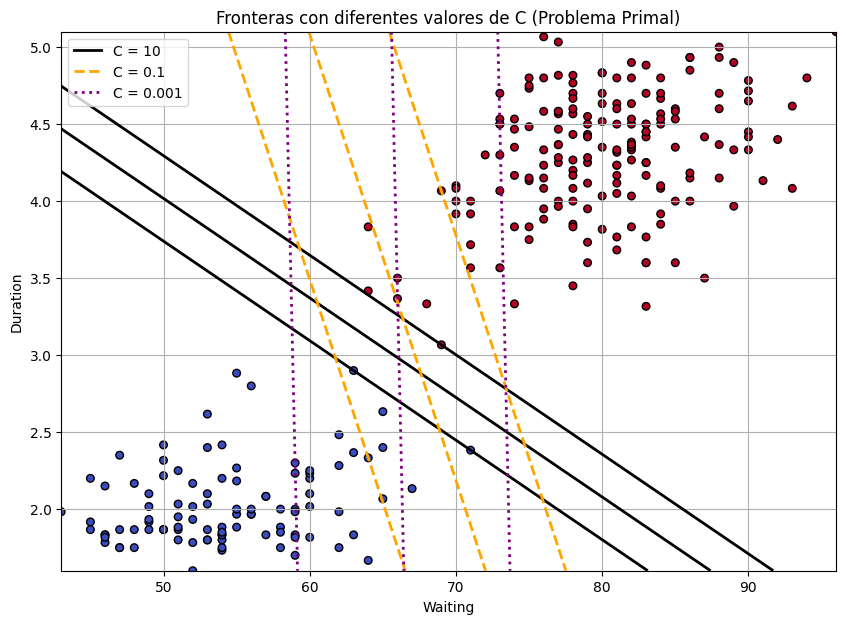

In [9]:
# Entrenar modelos SVM (primal) con distintos valores de C
model_C10 = SVM(C=10, soft=True,dual=False)
model_C10.fit(X, y)

model_C01 = SVM(C=0.1, soft=True,dual=False)
model_C01.fit(X, y)

model_C0001 = SVM(C=0.001, soft=True,dual=False)
model_C0001.fit(X, y)

# Malla para evaluar
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

Z10 = model_C10.decision_function(grid).reshape(xx.shape)
Z01 = model_C01.decision_function(grid).reshape(xx.shape)
Z0001 = model_C0001.decision_function(grid).reshape(xx.shape)

# ------------------ GRAFICAR -------------------
plt.figure(figsize=(10, 7))

# Scatter de los puntos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Fronteras
plt.contour(xx, yy, Z10, levels=[-1, 0, 1], colors='black', linestyles='-', linewidths=2)
plt.contour(xx, yy, Z01, levels=[-1, 0, 1], colors='orange', linestyles='--', linewidths=2)
plt.contour(xx, yy, Z0001, levels=[-1, 0, 1], colors='purple', linestyles=':', linewidths=2)


legend_lines = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='C = 10'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='C = 0.1'),
    Line2D([0], [0], color='purple', linestyle=':', linewidth=2, label='C = 0.001')
]
plt.legend(handles=legend_lines)

plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Fronteras con diferentes valores de C (Problema Primal)')
plt.grid(True)
plt.show()


### **SVM dual con Soft Margin**

En el caso de soft-margin, permitimos errores en la clasificación mediante **variables de holgura** $ \xi_i \geq 0 $. El objetivo es encontrar un equilibrio entre maximizar el margen y minimizar el error, controlado por un hiperparámetro $ C $.

Partimos del problema primal:

$$
\begin{aligned}
J_1 = \min_{w, b, \xi} \quad & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{sujeto a} \quad & y_i(w^T \phi(x_i) + b) \geq 1 - \xi_i \\
& \xi_i \geq 0 \quad \forall i
\end{aligned}
$$


Introducimos los multiplicadores de Lagrange:

- $ \alpha_i \geq 0 $ para $ y_i(w^T \phi(x_i) + b) \geq 1 - \xi_i $
- $ \mu_i \geq 0 $ para $ \xi_i \geq 0 $

Entonces queda de la siguiente manera:

$$
J_1 = \min_{w, b} \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i - \sum_{i=1}^{n} \alpha_i [y_i(w^T \phi(x_i) + b) - 1 + \xi_i] - \sum_{i=1}^{n} \mu_i \xi_i
$$

Agrupando términos:

$$
J_1 = \min_{w, b} \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i w^T \phi(x_i) - b \sum_{i=1}^{n} \alpha_i y_i + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - \mu_i)
$$

Por lo tanto, el problema dual con soft margins queda:

$$
J_2 = \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i w^T \phi(x_i) - b \sum_{i=1}^{n} \alpha_i y_i + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - \mu_i)
$$


Para poder minimizar con respecto a $w$ y $b$ calculamos las derivadas parciales:

1. Derivada respecto a $ w $:

$$
\frac{\partial J_2}{\partial w} = w - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0 \Rightarrow \boxed{w = \sum_{i=1}^n \alpha_i y_i \phi(x_i)}
$$

2. Derivada respecto a $ b $:

$$
\frac{\partial J_2}{\partial b} = -\sum_{i=1}^n \alpha_i y_i = 0 \Rightarrow \boxed{\sum_{i=1}^n \alpha_i y_i = 0}
$$

3. Derivada respecto a $ \xi_i $:

$$
\frac{\partial J_2}{\partial \xi_i} = C - \alpha_i - \mu_i = 0 \Rightarrow \boxed{\mu_i = C - \alpha_i}
$$

De ésta última, como sabemos que $\mu_i \geq 0$ (del mismo modo $\alpha_i \geq 0$ y $C > 0$), entonces se llega a que:

$$
\Rightarrow \boxed{0 \leq \alpha_i \leq C}
$$


Reemplazamos todas éstas expresiones encontradas en $J_2$:

$$
J_2 = \max_{\substack{0 \leq \alpha_i \leq C}} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i \phi(x_i)^T w + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - (C - \alpha_i))
$$

- El término con $ b $ desaparece porque $ \sum \alpha_i y_i = 0 $
- $\sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) = w^T \sum_{i=1}^n \alpha_i y_i \phi(x_i) = w^T w = \| w\|^2$
- El último término tambien se anula.

Por lo tanto, reescribiendo:


$$
J_2 = \max_{0 \leq \alpha_i \leq C} \sum_{i=1}^n \alpha_i - \| w \|^2
$$

$\| w \|^2$ se convierte en una suma doble utilizando el resultado de $w$:

$$
\begin{aligned}
\|w\|^2 &= \left\| \sum_{i=1}^n \alpha_i y_i \phi(x_i) \right\|^2 \\
&= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \phi(x_i)^T \phi(x_j)
\end{aligned}
$$

Con esto podemos definir la **matriz $ Q $** como:

$$
Q_{ij} = y_i y_j \phi(x_i)^T \phi(x_j)
$$

Por lo tanto, podemos escribir la norma como:

$$
\|w\|^2 = \alpha^T Q \alpha
$$

Entonces el problema dual soft-margin queda:

$$
\begin{aligned}
\max_{\alpha} \quad & \mathbf{1}^T \alpha - \frac{1}{2} \alpha^T Q \alpha \\
\text{sujeto a} \quad & \alpha^T y = 0 \\
& 0 \leq \alpha_i \leq C \quad \forall i
\end{aligned}
$$

Basicamente la expresión es igual a la del problema dual con hard margins, pero ahora $\alpha$ tiene a $C$ como cota superior.

El sesgo $ b $, en el problema dual, se puede estimar de la siguiente forma:

$$
b = \frac{1}{N_S} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j \in \mathcal{S}} \alpha_j y_j \phi(x_j)^T \phi(x_i) \right)
$$

donde $\mathcal{S}$ es el conjunto de índices de vectores soporte y $N_s$ la cantidad de elementos de dicho conjunto.



---

Este problema también puede resolverse mediante programación cuadrática (QP). La diferencia clave con el hard-margin es la restricción superior $ \alpha_i \leq C $, que permite errores en la clasificación (soft margin).




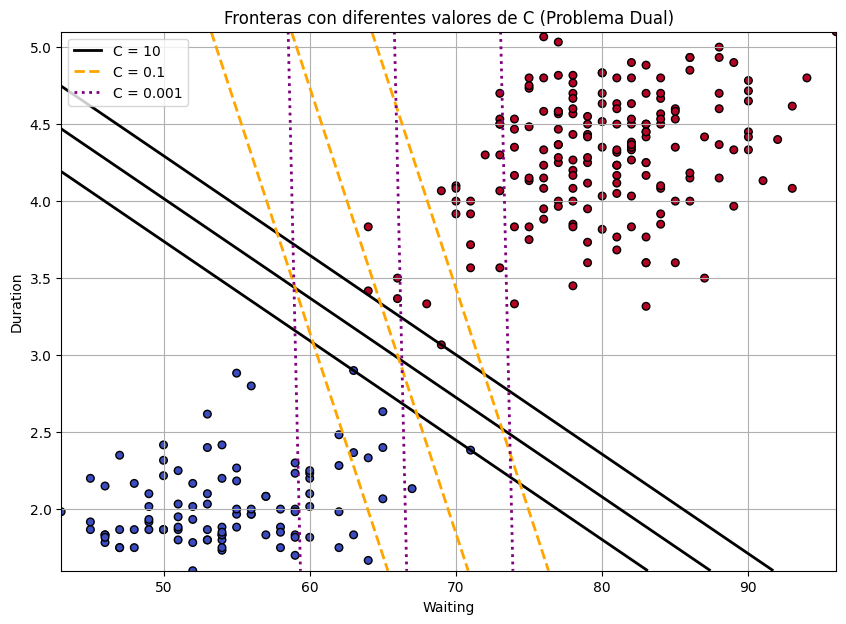

In [ ]:
# Entrenar modelos SVM (dual) con distintos valores de C
model_dual_C10 = SVM(C=10, dual=True)
model_dual_C10.fit(X, y)

model_dual_C01 = SVM(C=0.1, dual=True)
model_dual_C01.fit(X, y)

model_dual_C0001 = SVM(C=0.001, dual=True)
model_dual_C0001.fit(X, y)

# Malla para evaluar
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_dual_10 = model_dual_C10.decision_function(grid).reshape(xx.shape)
Z_dual_01 = model_dual_C01.decision_function(grid).reshape(xx.shape)
Z_dual_0001 = model_dual_C0001.decision_function(grid).reshape(xx.shape)


plt.figure(figsize=(10, 7))

# Scatter de los puntos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Fronteras
plt.contour(xx, yy, Z_dual_10, levels=[-1, 0, 1], colors='black', linestyles='-', linewidths=2)
plt.contour(xx, yy, Z_dual_01, levels=[-1, 0, 1], colors='orange', linestyles='--', linewidths=2)
plt.contour(xx, yy, Z_dual_0001, levels=[-1, 0, 1], colors='purple', linestyles=':', linewidths=2)

# Leyenda
legend_lines = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='C = 10'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='C = 0.1'),
    Line2D([0], [0], color='purple', linestyle=':', linewidth=2, label='C = 0.001')
]
plt.legend(handles=legend_lines)

plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Fronteras con diferentes valores de C (Problema Dual)')
plt.grid(True)
plt.show()


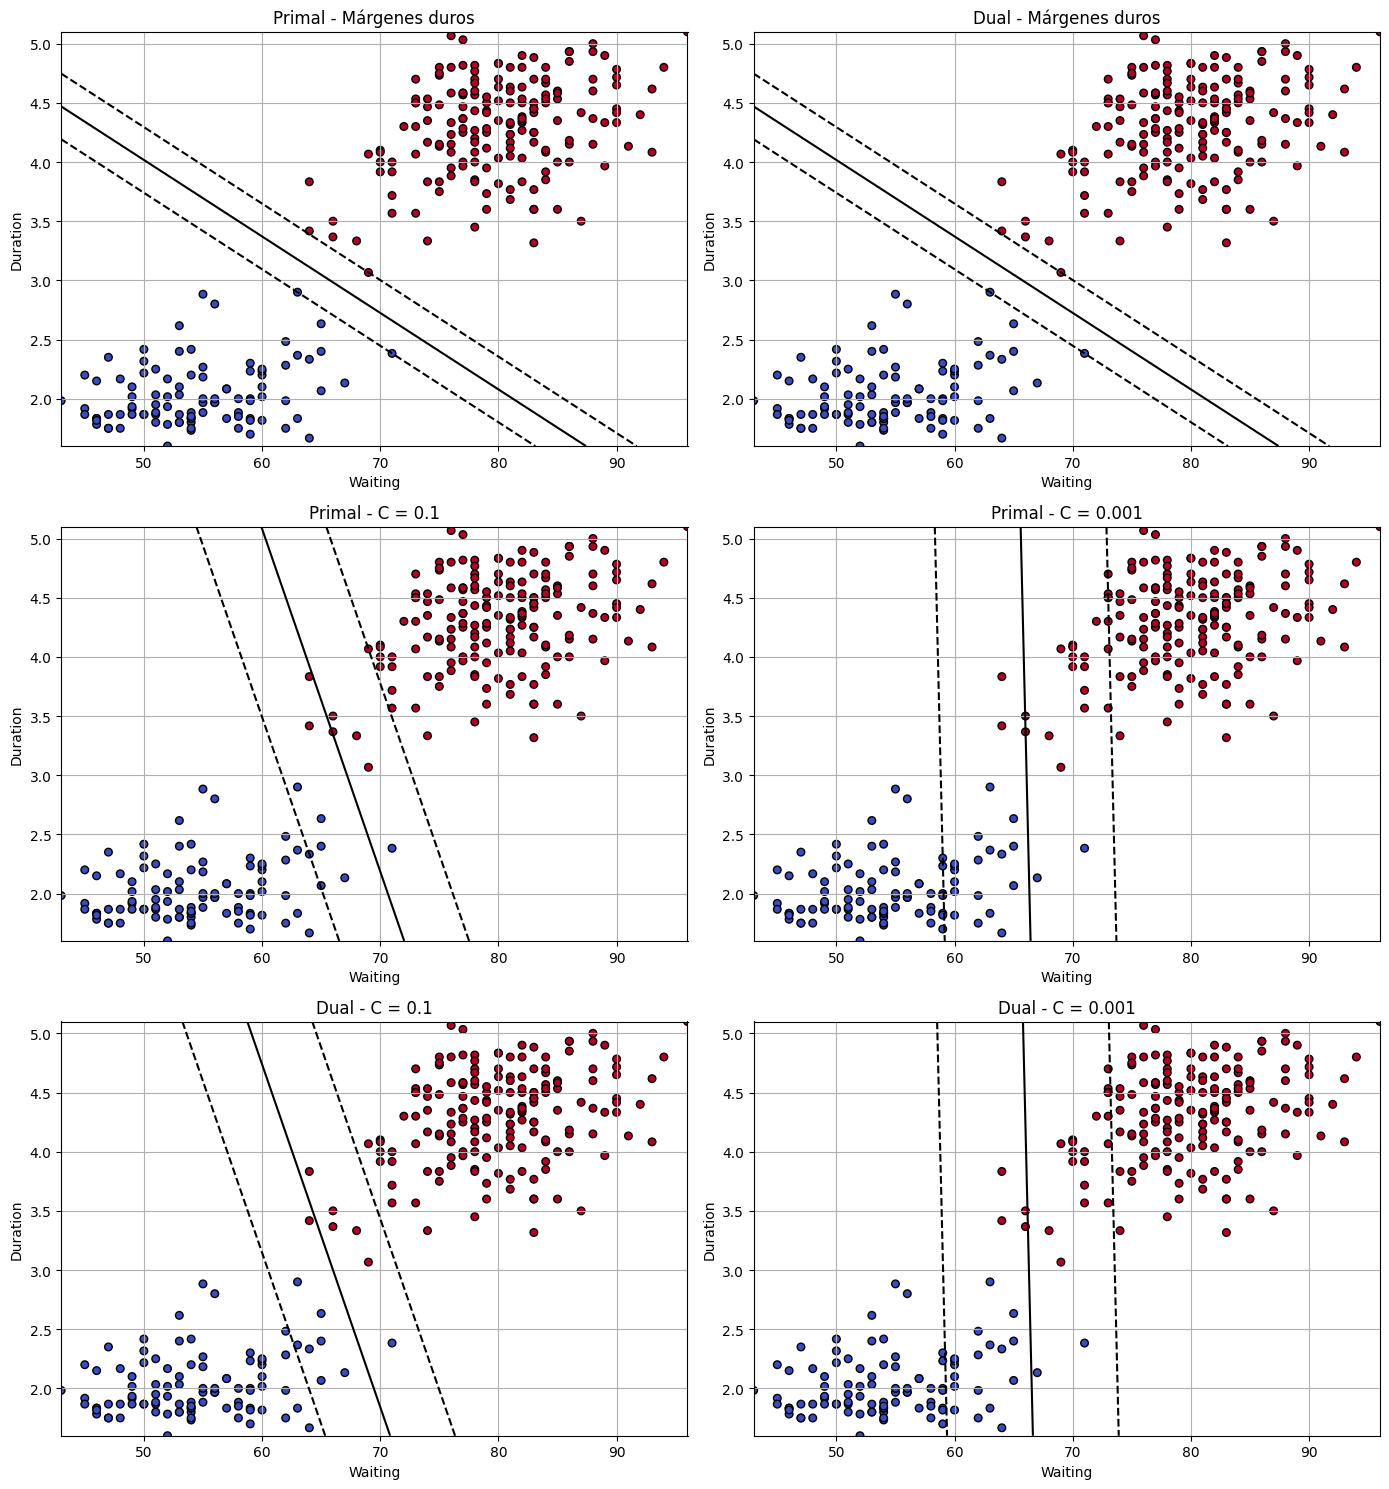

In [ ]:

# Función auxiliar para graficar una frontera SVM
def plot_decision_boundary(ax, model, X, y, title):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid).reshape(xx.shape)

    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=30)
    ax.set_title(title)
    ax.set_xlabel("Waiting")
    ax.set_ylabel("Duration")
    ax.grid(True)

# Creamos los modelos previamente (asegurate de tener estas clases/modelos listos):
# - model_primal_hard
# - model_dual_hard
# - model_primal_C001, model_primal_C0001
# - model_dual_C001, model_dual_C0001

# --- Entrená estos si no están listos ---
# (O adaptá a los nombres que ya tenés)
model_primal_hard = SVM(C=1e6, dual=False)  # C grande ≈ margen duro
model_primal_hard.fit(X, y)

model_dual_hard = SVM(C=1e6, dual=True)
model_dual_hard.fit(X, y)

model_primal_C01 = SVM(C=0.1, dual=False)
model_primal_C01.fit(X, y)

model_primal_C001 = SVM(C=0.001, dual=False)
model_primal_C001.fit(X, y)

model_dual_C01 = SVM(C=0.1, dual=True)
model_dual_C01.fit(X, y)

model_dual_C001 = SVM(C=0.001, dual=True)
model_dual_C001.fit(X, y)

# --- Crear figura con subplots ---
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

plot_decision_boundary(axes[0, 0], model_primal_hard, X, y, "Primal - Márgenes duros")
plot_decision_boundary(axes[0, 1], model_dual_hard, X, y, "Dual - Márgenes duros")

plot_decision_boundary(axes[1, 0], model_primal_C01, X, y, "Primal - C = 0.1")
plot_decision_boundary(axes[1, 1], model_primal_C001, X, y, "Primal - C = 0.001")

plot_decision_boundary(axes[2, 0], model_dual_C01, X, y, "Dual - C = 0.1")
plot_decision_boundary(axes[2, 1], model_dual_C001, X, y, "Dual - C = 0.001")

plt.tight_layout()
plt.show()
